Import libraries

In [1]:
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import plotly.graph_objs as go
from IPython.display import Image

In [2]:
import nltk
from nltk.corpus import wordnet as wn
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Francesco\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
wn_sysnets ={'Horse': wn.synset('horse.n.01'),
             'Cat': wn.synset('cat.n.01'),
             'Bird': wn.synset('bird.n.01'),
             'Cow': wn.synset('bovid.n.01'),
             'Dog': wn.synset('dog.n.01'),
             'Sheep': wn.synset('sheep.n.01'),
             'Aeroplane': wn.synset('airplane.n.01'),
             'Bicycle': wn.synset('bicycle.n.01'),
             'Bottle': wn.synset('bottle.n.01'),
             'Bus': wn.synset('bus.n.01'),
             'Car': wn.synset('car.n.01'),
             'Motorbike': wn.synset('motorcycle.n.01'),
             'Train': wn.synset('train.n.01')}

MAX_LVL = 5

**EVALUATION**

**Load the Causal metrics AUC values and analyze them**

In [57]:
#@title
# load the Causal metrics AUC curves results
with open('../VOC_curves.json') as json_file: 
  curves_dict = json.load(json_file)

# intermediate dictionaries to record
holmes_deletion_auc_dict = {}
holmes_insertion_auc_dict = {}
holmes_preservation_auc_dict = {}
gradcam_deletion_auc_dict = {}
gradcam_insertion_auc_dict = {}
gradcam_preservation_auc_dict = {}
pred_class_dict = {}
num_pred_dict = {}

holonyms = list(curves_dict.keys())
for i, holonym in enumerate(holonyms):
  if holonym not in wn_sysnets:
    continue
  holonym_dict = curves_dict[holonym]      # holonym class dict
  holonym_img_names = curves_dict[holonym]['curves'].keys() # VOC validation images for the holonym

  for j, img_name in enumerate(holonym_img_names):
    if j == 0:
        holmes_deletion_auc_dict[holonym] = []
        holmes_insertion_auc_dict[holonym] = []
        holmes_preservation_auc_dict[holonym] = []
        gradcam_deletion_auc_dict[holonym] = []
        gradcam_insertion_auc_dict[holonym] = []
        gradcam_preservation_auc_dict[holonym] = []        
        pred_class_dict[holonym] = []
        num_pred_dict[holonym] = 0
    elif j>=50:
      break
    
    img_pred_class = holonym_dict['curves'][img_name]['pred_class']

    # list of pred values
    pred_class_dict[holonym].append(img_pred_class)
    # check if the hyponym prediction can be mapped to a holonym
    # first extract the predicted class synsets
    syns = wn.synsets(img_pred_class.replace(" ", "_"))
    #print("{} -> {}".format(img_pred_class, syns))
    # iterate on each synset
    found = 0
    for syn in syns:
        # look for the holonym as an hypernym up to a certain hierarchy level
        for lvl in range(MAX_LVL):
            if syn == wn_sysnets[holonym]:
                # found
                found = 1
                break
            else:
                # climb up the hierarchy
                hypernyms = syn.hypernyms()
                if not hypernyms:
                    break
                syn = hypernyms[0]    

        if found == 1:
            break
    if found == 0:
        continue
    #print("{} -> {}".format(img_pred_class, syn))
    
    num_pred_dict[holonym] += 1
    # holmes
    img_holmes_deletion_auc = holonym_dict['curves'][img_name]['holmes_deletion']
    img_holmes_insertion_auc = holonym_dict['curves'][img_name]['holmes_insertion']
    img_holmes_preservation_auc = holonym_dict['curves'][img_name]['holmes_preservation']
    # list of aucs
    holmes_deletion_auc_dict[holonym].append(img_holmes_deletion_auc)
    holmes_insertion_auc_dict[holonym].append(img_holmes_insertion_auc)
    holmes_preservation_auc_dict[holonym].append(img_holmes_preservation_auc)
    # gradcam    
    img_gradcam_deletion_auc = holonym_dict['curves'][img_name]['gradcam_deletion']
    img_gradcam_insertion_auc = holonym_dict['curves'][img_name]['gradcam_insertion']
    img_gradcam_preservation_auc = holonym_dict['curves'][img_name]['gradcam_preservation']
    # list of aucs
    gradcam_deletion_auc_dict[holonym].append(img_gradcam_deletion_auc)
    gradcam_insertion_auc_dict[holonym].append(img_gradcam_insertion_auc)
    gradcam_preservation_auc_dict[holonym].append(img_gradcam_preservation_auc)
    
  #average_ratio_auc_per_holonym_meronym_dict = {k:np.mean(v, axis=0) for k,v in ratio_auc_dict.items()}

  #average_ratio_auc_per_holonym_dict = {k:np.mean(v, axis=None) for k,v in ratio_auc_dict.items()}

In [58]:
num_pred_dict

{'Horse': 17,
 'Cat': 25,
 'Bird': 35,
 'Cow': 36,
 'Dog': 37,
 'Sheep': 25,
 'Aeroplane': 33,
 'Bicycle': 24,
 'Bottle': 4,
 'Bus': 33,
 'Car': 25,
 'Motorbike': 5,
 'Train': 2}

**Calculate average of the causal metrics separately for each holonym -> for each holonym the number or correctly predicted images is different**

In [59]:
# calculate average of the causal metrics separately for each holonym
holmes_holonyms_avg_deletion = {}
holmes_holonyms_avg_insertion = {}
holmes_holonyms_avg_preservation = {}
gradcam_holonyms_avg_deletion = {}
gradcam_holonyms_avg_insertion = {}
gradcam_holonyms_avg_preservation = {}

ratio_holonyms_avg_deletion = {}
ratio_holonyms_avg_insertion = {}
ratio_holonyms_avg_preservation = {}

for i, holonym in enumerate(holonyms):
    holmes_holonyms_avg_deletion[holonym] = np.mean(holmes_deletion_auc_dict[holonym])
    holmes_holonyms_avg_insertion[holonym] = np.mean(holmes_insertion_auc_dict[holonym])
    holmes_holonyms_avg_preservation[holonym] = np.mean(holmes_preservation_auc_dict[holonym])
    
    gradcam_holonyms_avg_deletion[holonym] = np.mean(gradcam_deletion_auc_dict[holonym])
    gradcam_holonyms_avg_insertion[holonym] = np.mean(gradcam_insertion_auc_dict[holonym])
    gradcam_holonyms_avg_preservation[holonym] = np.mean(gradcam_preservation_auc_dict[holonym])
    
    ratio_holonyms_avg_deletion[holonym] = holmes_holonyms_avg_deletion[holonym] / gradcam_holonyms_avg_deletion[holonym]
    ratio_holonyms_avg_insertion[holonym] = holmes_holonyms_avg_insertion[holonym] / gradcam_holonyms_avg_insertion[holonym]
    ratio_holonyms_avg_preservation[holonym] = holmes_holonyms_avg_preservation[holonym] / gradcam_holonyms_avg_preservation[holonym]

Show results

In [86]:
holmes_holonyms_avg_deletion

{'Horse': 0.054146665186202196,
 'Cat': 0.029415107007415717,
 'Bird': 0.06993064271252532,
 'Cow': 0.055960823588159445,
 'Dog': 0.030758937097352123,
 'Sheep': 0.03902180450262154,
 'Aeroplane': 0.08034495524678667,
 'Bicycle': 0.06862324181316644,
 'Bottle': 0.04961061069800515,
 'Bus': 0.047137351450336346,
 'Car': 0.041211137878425515,
 'Motorbike': 0.06980957613697122,
 'Train': 0.12090586565608216}

In [87]:
holmes_holonyms_avg_insertion

{'Horse': 0.4992077107104098,
 'Cat': 0.3322205835266886,
 'Bird': 0.5802928810731007,
 'Cow': 0.40203068091448574,
 'Dog': 0.3298171832435733,
 'Sheep': 0.4183514431556944,
 'Aeroplane': 0.819464978282122,
 'Bicycle': 0.45108734089950936,
 'Bottle': 0.443965732232024,
 'Bus': 0.5824857198240014,
 'Car': 0.40329476161423344,
 'Motorbike': 0.35952614533482896,
 'Train': 0.6554957886531025}

In [88]:
holmes_holonyms_avg_preservation

{'Horse': 0.3101034238932741,
 'Cat': 0.278842049121386,
 'Bird': 0.5062079817887772,
 'Cow': 0.371611333303278,
 'Dog': 0.28301406419774766,
 'Sheep': 0.3948578472692176,
 'Aeroplane': 0.6476600416840022,
 'Bicycle': 0.2886086118818055,
 'Bottle': 0.29821224899961196,
 'Bus': 0.4409981519868343,
 'Car': 0.27546336104470703,
 'Motorbike': 0.2905720520996437,
 'Train': 0.31637731723629425}

In [60]:
# lower is better
ratio_holonyms_avg_deletion

{'Horse': 1.1463449190723127,
 'Cat': 1.3289362032917627,
 'Bird': 1.0457509480933112,
 'Cow': 1.4887918482259637,
 'Dog': 0.959725287239363,
 'Sheep': 0.7908113215240821,
 'Aeroplane': 0.7738376694120718,
 'Bicycle': 1.2890431116038694,
 'Bottle': 1.2366285373543155,
 'Bus': 1.0346164571934318,
 'Car': 0.7999687758464439,
 'Motorbike': 0.9252060863896625,
 'Train': 0.932472082255984}

In [61]:
# higher is better
ratio_holonyms_avg_insertion

{'Horse': 0.9177289498321094,
 'Cat': 0.8731929635852377,
 'Bird': 0.9882017187940048,
 'Cow': 0.9285830707671169,
 'Dog': 0.9250828504818756,
 'Sheep': 0.9883723404755911,
 'Aeroplane': 0.9865671945671408,
 'Bicycle': 0.8277669858062612,
 'Bottle': 0.8904785631993427,
 'Bus': 1.0605737306905063,
 'Car': 1.0229585458428205,
 'Motorbike': 1.1508890994032017,
 'Train': 0.9343108787246291}

In [62]:
# bigger is better
ratio_holonyms_avg_preservation

{'Horse': 1.0494729026529046,
 'Cat': 0.9574876386871779,
 'Bird': 1.0012669058769368,
 'Cow': 1.0275324910945667,
 'Dog': 0.9500045377415441,
 'Sheep': 0.9678740731906195,
 'Aeroplane': 1.0775935462037194,
 'Bicycle': 0.8122917599150304,
 'Bottle': 0.7984981981266704,
 'Bus': 1.27632250909948,
 'Car': 0.9479032772456064,
 'Motorbike': 1.1061281039958188,
 'Train': 0.8487154088219957}

**Calculate the average of the causal metrics over all images of all holonyms -> overall evaluation regardless of the number correctly predicted images for each holonym**

In [63]:
# calculate the average of the causal metrics over all images of all holonyms
holmes_all_deletion = []
holmes_all_insertion = []
holmes_all_preservation = []
gradcam_all_deletion = []
gradcam_all_insertion = []
gradcam_all_preservation = []

for i, holonym in enumerate(holonyms):
    holmes_all_deletion.append(holmes_deletion_auc_dict[holonym])
    holmes_all_insertion.append(holmes_insertion_auc_dict[holonym])
    holmes_all_preservation.append(holmes_preservation_auc_dict[holonym])
    
    gradcam_all_deletion.append(gradcam_deletion_auc_dict[holonym])
    gradcam_all_insertion.append(gradcam_insertion_auc_dict[holonym])
    gradcam_all_preservation.append(gradcam_preservation_auc_dict[holonym])
    

# convert from list of lists to simple list
holmes_all_deletion = sum(holmes_all_deletion, [])
holmes_all_insertion = sum(holmes_all_insertion, [])
holmes_all_preservation = sum(holmes_all_preservation, [])
gradcam_all_deletion = sum(gradcam_all_deletion, [])
gradcam_all_insertion = sum(gradcam_all_insertion, [])
gradcam_all_preservation = sum(gradcam_all_preservation, [])

holmes_all_deletion_avg = np.mean(holmes_all_deletion)
holmes_all_deletion_std = np.std(holmes_all_deletion)
holmes_all_insertion_avg = np.mean(holmes_all_insertion)
holmes_all_insertion_std = np.std(holmes_all_insertion)
holmes_all_preservation_avg = np.mean(holmes_all_preservation)
holmes_all_preservation_std = np.std(holmes_all_preservation)
gradcam_all_deletion_avg = np.mean(gradcam_all_deletion)
gradcam_all_deletion_std = np.std(gradcam_all_deletion)
gradcam_all_insertion_avg = np.mean(gradcam_all_insertion)
gradcam_all_insertion_std = np.std(gradcam_all_insertion)
gradcam_all_preservation_avg = np.mean(gradcam_all_preservation)
gradcam_all_preservation_std = np.std(gradcam_all_preservation)

ratio_all_deletion = holmes_all_deletion_avg/gradcam_all_deletion_avg
ratio_all_insertion = holmes_all_insertion_avg/gradcam_all_insertion_avg
ratio_all_preservation = holmes_all_preservation_avg/gradcam_all_preservation_avg

Show results

In [66]:
print("Holmes avg deletion: {} +- {}".format(round(holmes_all_deletion_avg, 3), round(holmes_all_deletion_std, 3)))

Holmes avg deletion: 0.053 +- 0.063


In [73]:
print("GradCAM avg deletion: {} +- {}".format(round(gradcam_all_deletion_avg, 3), round(gradcam_all_deletion_std, 3)))

GradCAM avg deletion: 0.052 +- 0.06


In [75]:
# lower is better
print("Holmes-GradCAM avg deletion ratio: {}".format(round(ratio_all_deletion, 3)))

Holmes-GradCAM avg deletion ratio: 1.009


In [77]:
print("Holmes avg insertion: {} +- {}".format(round(holmes_all_insertion_avg, 3), round(holmes_all_insertion_std, 3)))

Holmes avg insertion: 0.486 +- 0.267


In [79]:
print("GradCAM avg insertion: {} +- {}".format(round(gradcam_all_insertion_avg, 3), round(gradcam_all_insertion_std, 3)))

GradCAM avg insertion: 0.505 +- 0.277


In [81]:
# higher is better
print("Holmes-GradCAM avg insertion ratio: {}".format(round(ratio_all_insertion, 3)))

Holmes-GradCAM avg insertion ratio: 0.962


In [83]:
print("Holmes avg preservation: {} +- {}".format(round(holmes_all_preservation_avg, 3), round(holmes_all_preservation_std, 3)))

Holmes avg preservation: 0.388 +- 0.255


In [85]:
print("GradCAM avg preservation: {} +- {}".format(round(gradcam_all_preservation_avg, 3), round(gradcam_all_preservation_std, 3)))

GradCAM avg preservation: 0.381 +- 0.264


In [90]:
# higher is better
print("Holmes-GradCAM avg preservation ratio: {}".format(round(ratio_all_preservation, 3)))

Holmes-GradCAM avg preservation ratio: 1.016


In [99]:
plt.rcParams.update({'font.size': 15})

custom_lines = [Line2D([0], [0], color="royalblue", lw=5),
                Line2D([0], [0], color="darkorange", lw=5)]

def draw_distributions_comparison(dist_values_1, dist_values_2, title_1, title_2, better_str):
    x = [title_1, title_2]
    mean_dist_1 = (round(np.mean(dist_values_1), 3))
    mean_dist_2 = (round(np.mean(dist_values_2), 3))

    fig = plt.figure(figsize=(10,9))
    ax = sns.violinplot(data=[dist_values_1, dist_values_2])

    ax.text(0+0.02, np.mean(dist_values_1)-0.02, "mean=" + str(mean_dist_1)+ "\n("+ better_str + " is better)")
    ax.text(1+0.02, np.mean(dist_values_2)-0.02, "mean=" + str(mean_dist_2)+ "\n("+ better_str + " is better)")

    plt.xticks([], )
    plt.legend(custom_lines, x, loc='upper right')
    plt.title(title_1 + ' and ' + title_2)
    plt.show()

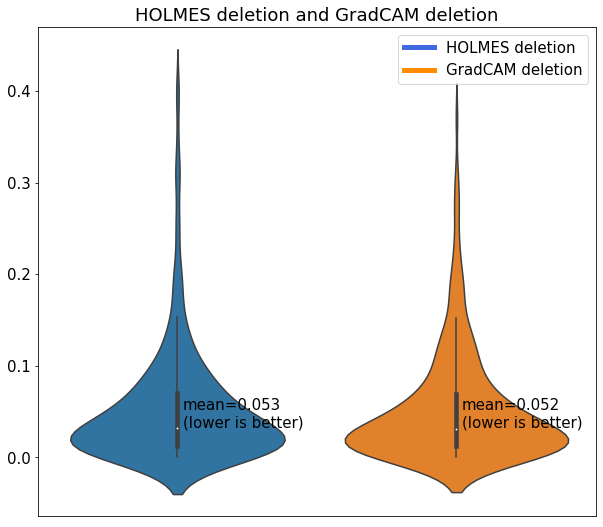

In [100]:
draw_distributions_comparison(holmes_all_deletion, gradcam_all_deletion, 'HOLMES deletion', 'GradCAM deletion', "lower")

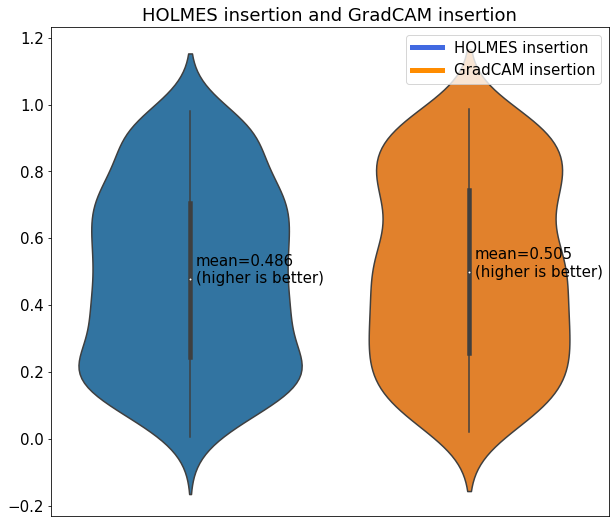

In [102]:
draw_distributions_comparison(holmes_all_insertion, gradcam_all_insertion, 'HOLMES insertion', 'GradCAM insertion', "higher")

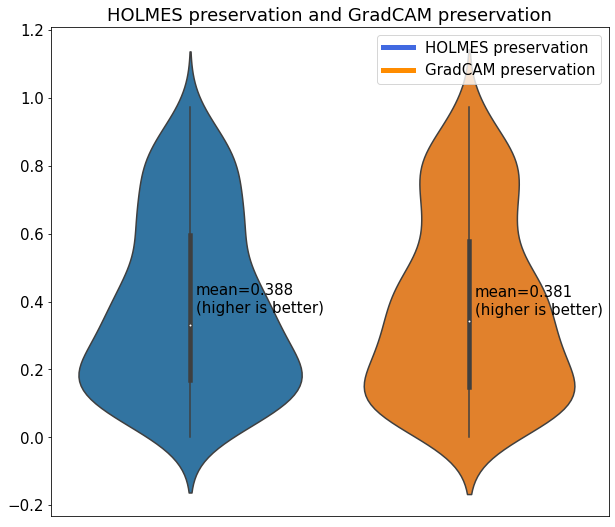

In [103]:
draw_distributions_comparison(holmes_all_preservation, gradcam_all_preservation, 'HOLMES preservation', 'GradCAM preservation', "higher")